In [6]:
import re
import os
import string
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

ROOT_DIR = os.path.dirname(os.getcwd())
USER_CSV = os.path.join(ROOT_DIR, 'output', 'users', 'objs', '2022-02-06', 'user-objs-orig.csv')
LOCATIONS_JSON = os.path.join(ROOT_DIR, 'input', 'locations.json')

locations = pd.read_json(LOCATIONS_JSON)[0]
locations = [loc.lower() for loc in locations]

INPUT = {
    'user_id'        : pd.Int64Dtype(),
    'protected'      : pd.BooleanDtype(),
    'screen_name'    : pd.StringDtype(),
    'location'       : pd.StringDtype(),
    'name'           : pd.StringDtype(),
    'description'    : pd.StringDtype(),
    'verified'       : pd.BooleanDtype(),
    'created_at'     : pd.StringDtype(),
    'statuses_count' : pd.Int64Dtype(),
    'friends_count'  : pd.Int64Dtype(),
    'followers_count': pd.Int64Dtype(),
}

OUTPUT = {
    'user_id'        : pd.Int64Dtype(),
    'protected'      : pd.BooleanDtype(),
    'screen_name'    : pd.StringDtype(),
    'location'       : pd.StringDtype(),
    'created_at'     : dt.datetime,
}

#user_df = pd.read_csv(USER_CSV, dtype=INPUT)
user_df = pd.read_csv('C:\\Users\\AndreaHrelja\\Documents\\Faks\\twitter_scraper\\output\\users\\objs\\2022-02-03\\user-objs.csv')
user_df = user_df[user_df['protected'] == False]
user_df['created_at'] = pd.to_datetime(user_df['created_at'], format='%a %b %d %H:%M:%S %z %Y') # 30s
user_df.info()

c:\Users\AndreaHrelja\Documents\Faks\twitter_scraper\input\locations.json
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1649613 entries, 0 to 1788233
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype              
---  ------           --------------    -----              
 0   user_id          1649613 non-null  int64              
 1   location         954700 non-null   object             
 2   screen_name      1649613 non-null  object             
 3   name             1646580 non-null  object             
 4   statuses_count   1649613 non-null  int64              
 5   friends_count    1649613 non-null  int64              
 6   followers_count  1649613 non-null  int64              
 7   description      1167333 non-null  object             
 8   created_at       1649613 non-null  datetime64[ns, UTC]
 9   verified         1649613 non-null  bool               
 10  protected        1649613 non-null  bool               
dtypes: bool(2), datetime64[ns, U

<AxesSubplot:>

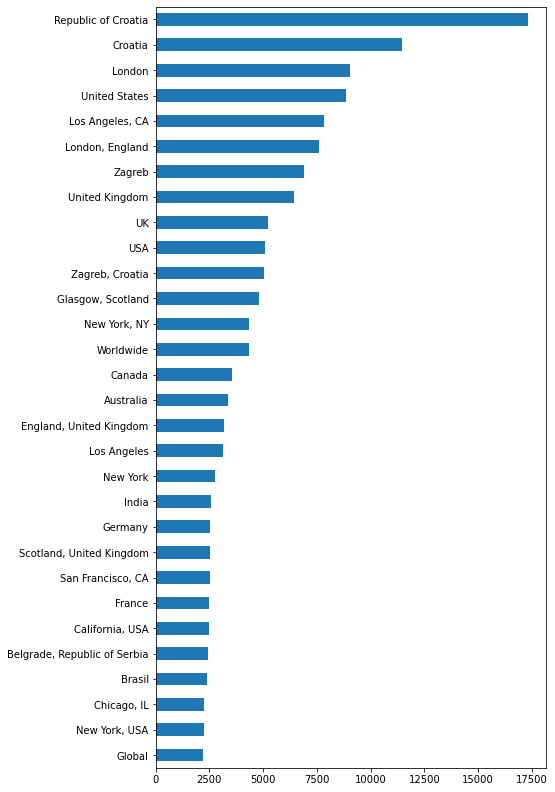

In [22]:
user_df.location.value_counts(ascending=False).head(30)[::-1].plot.barh(figsize=(7, 14))

In [7]:
accepted_chars = string.ascii_lowercase + 'čšćžđ'

def clean_location(location):
    if location == '':
        return location
    
    new_location = location.lower()
    location_names = ('republic of croatia', 'republika hrvatska', 'hrvatska', 'croatia', 'croacia', 'croatie')
    
    if re.search(r'[ ]+', location):
        new_location = new_location.replace(re.search(r'[ ]+', location).group(), ' ').strip()
    
    for name in location_names:
        if new_location == name:
            return 'Hrvatska'
    
        for char in location.lower():
            if char not in accepted_chars + ' ':
                new_location = new_location.replace(char, '')
        
        if name in location.lower():
            new_location = new_location.replace(name, '')
        new_location = new_location.strip()
        
    if new_location == '':
        new_location = 'Hrvatska'
    return new_location.title()


def is_croatian(location):
    global locations
    
    if location == '':
        return False
    
    cro_locations = ('croa', 'hrvat')
    
    if location.lower() in locations:
        return True
    else:
        return any(cro_loc in location.lower() for cro_loc in cro_locations)

user_df['is_croatian'] = user_df['location'].fillna('').transform(is_croatian)
user_df['clean_location'] = user_df[user_df['is_croatian'] == True]['location'].transform(clean_location)

In [8]:
#user_df['clean_location'] = user_df[user_df['is_croatian'] == True]['location'].fillna('').transform(clean_location)
#user_df.to_csv('cro-user-objs.csv', index=False)
user_df['croat'] = user_df['location'].fillna('').transform(lambda x: any(y in x.lower() for y in ('croa', 'hrv')) or x.lower() in locations)
user_df.croat.value_counts()

False    1586948
True       62665
Name: croat, dtype: int64

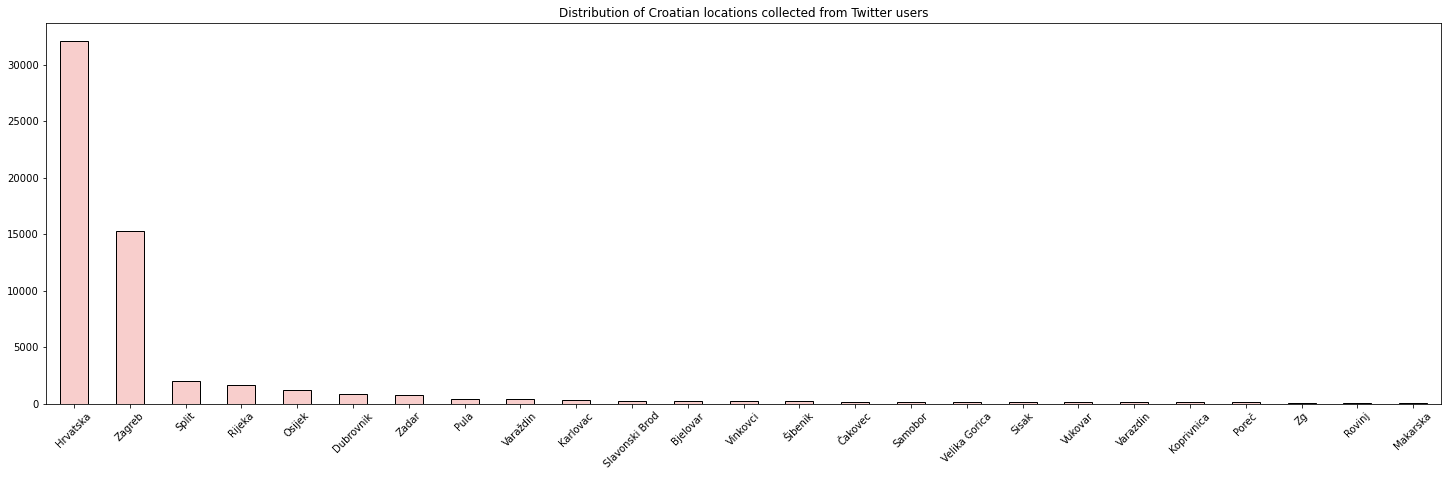

In [36]:
user_df['clean_location'] = user_df[user_df['croat'] == True]['location'].fillna('').transform(clean_location)
croatian_df = user_df[(user_df['croat'] == True) & (user_df['clean_location'] != 'Europe')]

croatian_df.groupby('clean_location').size() \
    .sort_values(ascending=False).head(25) \
    .plot.bar(
        title='Distribution of Croatian locations collected from Twitter users', 
        figsize=(25, 7), 
        rot=45, 
        #logy=True, 
        color='#f8cecc',
        edgecolor='black'
    )

plt.xlabel(None)
plt.show()

In [ ]:
df[
    (df['is_croatian'] == False)
    & (df['location'] != '<NA>')
].groupby('location').size() \
 .sort_values(ascending=False).head(50) \
 .iloc[::-1].plot.barh(title='Non-Croatian locations',figsize=(14, 20))
plt.show()

In [ ]:
len(df[df['is_croatian'] == True])

In [38]:
user_df = user_df.drop_duplicates('user_id')
user_df[
    (user_df['is_croatian'] == True)
    & (user_df['statuses_count'] > 10)
    & (user_df['friends_count'] > 10)
    & (user_df['friends_count'] < 5000)
    & (user_df['followers_count'] > 10)
    #& (user_df['followers_count'] < 5000)
].sort_values(by='friends_count', ascending=False) #.to_csv('new_baseline_user_ids.csv', encoding='utf-8', index=False)

,user_id,location,screen_name,name,statuses_count,friends_count,followers_count,description,created_at,verified,protected,is_croatian,clean_location,croat
1286861,3358478140,Republic of Croatia,klitorino,Zubi Vana Zu,1415,4999,1029,#faith #prophetic #ww3\r\n#teleportation #inti...,2015-07-04 10:27:47+00:00,False,False,True,Hrvatska,True
280876,680383,Croatia,BorraBomber,CEO Borra 🎩,38894,4998,1160,Kadrovik. Rokabili. 43. 🇪🇺🇭🇷,2007-01-22 12:43:01+00:00,False,False,True,Hrvatska,True
1513859,767070895403851776,Republic of Croatia,djordje_e,Đorđe,112,4997,567,NaN,2016-08-20 18:48:47+00:00,False,False,True,Hrvatska,True
1088413,1629958297,Zagreb/Croatia,tomcro2013,Tomislav Anić,2929,4996,678,NaN,2013-07-29 09:18:08+00:00,False,False,True,Zagreb,True
728647,215630332,Split - Croatia,Bozomegamix,Illyric Dalmatino,3723,4996,1221,"Worshiper, Charismatic, Prophetic, Open Source...",2010-11-14 13:46:30+00:00,False,False,True,Split,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374534,588103796,"Pula, Croatia",MladenJergovic,Mladen Jergović,1797,11,164,NaN,2012-05-23 07:58:27+00:00,False,False,True,Pula,True
1348982,49316644,Croatia,CroatiaFFE,Croatia FFE,15,11,39,Mi smo Croatia FFE i tu smo da vas u kratkim c...,2009-06-21 13:42:42+00:00,False,False,True,Hrvatska,True
999080,794917227426365440,"Zagreb, Croatia",sekretarium,Sek,182,11,33,Twitch Streamer on occasion🎮| DIY & Survival e...,2016-11-05 15:00:10+00:00,False,False,True,Zagreb,True
1346314,279996981,Zagreb,arwenlarpshop,Arwen LARP shop,11,11,32,First LARP store in Croatia,2011-04-10 12:29:48+00:00,False,False,True,Zagreb,True


In [46]:
# output_baseline_ids

output_df = user_df[
    (user_df['is_croatian'] == True)
    & (user_df['statuses_count'] > 10)
    & (user_df['friends_count'] > 10)
    & (user_df['friends_count'] < 5000)
    & (user_df['followers_count'] > 10)
    #& (user_df['followers_count'] < 5000)
].sort_values(by='followers_count')

#output_df.user_id.to_json('../../input/new-baseline-user-ids.json', orient='records', indent=2)
output_df

,user_id,location,screen_name,name,statuses_count,friends_count,followers_count,description,created_at,verified,protected,is_croatian,clean_location,croat
753233,4540013663,Republic of Croatia,ivo_miljanovic,Ivo Miljanović,40,127,11,Prehospital EM doc. Love $Foam .,2015-12-19 22:52:17+00:00,False,False,True,Hrvatska,True
465846,1578174655,CROATIA,DanijelMatoc,Danijel Matoc,21,158,11,NaN,2013-07-08 17:11:32+00:00,False,False,True,Hrvatska,True
59542,867099155579142144,"Zagreb, Croatia",JohnyXsenpai,Johny@Senpai,386,93,11,"Graphic designer, illustrator,artist, draw com...",2017-05-23 19:25:23+00:00,False,False,True,Zagreb,True
575013,441772343,Split,Saint996,Ante Babic,34,132,11,"17 years...go-kart,cars and architecture lover !",2011-12-20 12:01:13+00:00,False,False,True,Split,True
86601,818101040,Zagreb/Croatia,zliPula,Zli,18,30,11,NaN,2012-09-11 20:11:55+00:00,False,False,True,Zagreb,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257472,80316128,Republic of Croatia,DNEVNIKhr,DNEVNIK.hr,144106,1146,236806,Saznajte prvi najvažnije informacije: https://...,2009-10-06 14:33:26+00:00,True,False,True,Hrvatska,True
1014213,790921536,Hrvatska | Croatia,HNS_CFF,HNS,17746,108,236985,Službeni Twitter profil Hrvatskog nogometnog s...,2012-08-30 05:56:36+00:00,True,False,True,Hrvatska,True
194132,1122522158486499329,Croatia🇭🇷Zadar🇭🇷,ana_zd88,✨ ANA ✨,473270,4705,320626,📷AV&H 💞 @solarkate1 💞,2019-04-28 15:25:12+00:00,False,False,True,Zadar,True
1643233,1648029396,Croatia,Perkz,Luka,3156,376,433666,🇭🇷\r\n23 years old. Professional League of Leg...,2013-08-05 15:36:04+00:00,True,False,True,Hrvatska,True


In [ ]:
import re
df['clean_location'] = df['clean_location'].transform(lambda x: x.replace(re.search('[ ]+', x).group(), ' ') if re.search('[ ]+', x) else x)
list(df[df['is_croatian'] == True].groupby('clean_location').size().sort_values(ascending=False).index)